# Setup

In [2]:
import numpy as np
from numpy.linalg import cholesky, solve
from numpy.random import randn
from scipy.linalg import cho_solve, cho_factor
from scipy.io import loadmat  # because the data is in matlab format
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.dates import date2num, num2date
from datetime import datetime

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [7]:
# colors:
dark = np.array([51.0, 51.0, 51.0]) / 255.0
red = np.array([141.0, 45.0, 57.0]) / 255.0
gold = np.array([174.0, 159.0, 109.0]) / 255.0
gray = np.array([175.0, 179.0, 183.0]) / 255.0
lred = np.array([1, 1, 1]) - 0.5 * (np.array([1, 1, 1]) - red)
lgold = np.array([1, 1, 1]) - 0.5 * (np.array([1, 1, 1]) - gold)
tuesec1 = np.array([65.0, 90.0, 140.0]) / 255.0  # blue 1
tuesec2 = np.array([0.0, 105.0, 170.0]) / 255.0  # blue 2
tuesec3 = np.array([80.0, 170.0, 200.0]) / 255.0  # blue 3
tuesec4 = np.array([130.0, 185.0, 160.0]) / 255.0  # green 1
tuesec5 = np.array([125.0, 165.0, 75.0]) / 255.0  # green 2
tuesec6 = np.array([50.0, 110.0, 30.0]) / 255.0  # green 3
tuesec7 = np.array([200.0, 80.0, 60.0]) / 255.0  # red 1
tuesec8 = np.array([175.0, 110.0, 150.0]) / 255.0  # red 2
tuesec9 = np.array([180.0, 160.0, 150.0]) / 255.0  # red 3
tuesec10 = np.array([215.0, 180.0, 105.0]) / 255.0  # yellow 1
tuesec11 = np.array([210.0, 150.0, 0.0]) / 255.0  # yellow 2
tuesec12 = np.array([145.0, 150.0, 70.0]) / 255.0  # yellow 3

## Load Data

In [3]:
data = loadmat("weightdata_clean.mat")
X = data["dat"][:, 0] - 366
# original data was recorded in matlab. python is 0-based, matlab 1-based, so we have to subtract one year and one day
Y = data["dat"][:, 1]
# secretkey = Y[0];  # for anomymity (this is just a shift, it will not change the outcome of the analysis)
# Y = Y - secretkey
N = X.size

sigma = 0.1  # precision of scale (=100g), used as std-dev of measurements.
# (No need to learn this, it's printed on the back of the scale)

In [4]:
Xd = num2date(X)  # for plotting vs human-readable dates

t = np.linspace(X[0], X[-1] + 365, 500)
# extrapolate for one year
Nt = t.size
td = num2date(t)

In [5]:
# range of the data
Xd[0], Xd[-1]

(datetime.datetime(2009, 3, 4, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2013, 7, 26, 9, 6, 18, 865820, tzinfo=datetime.timezone.utc))

First, a look at the raw data:

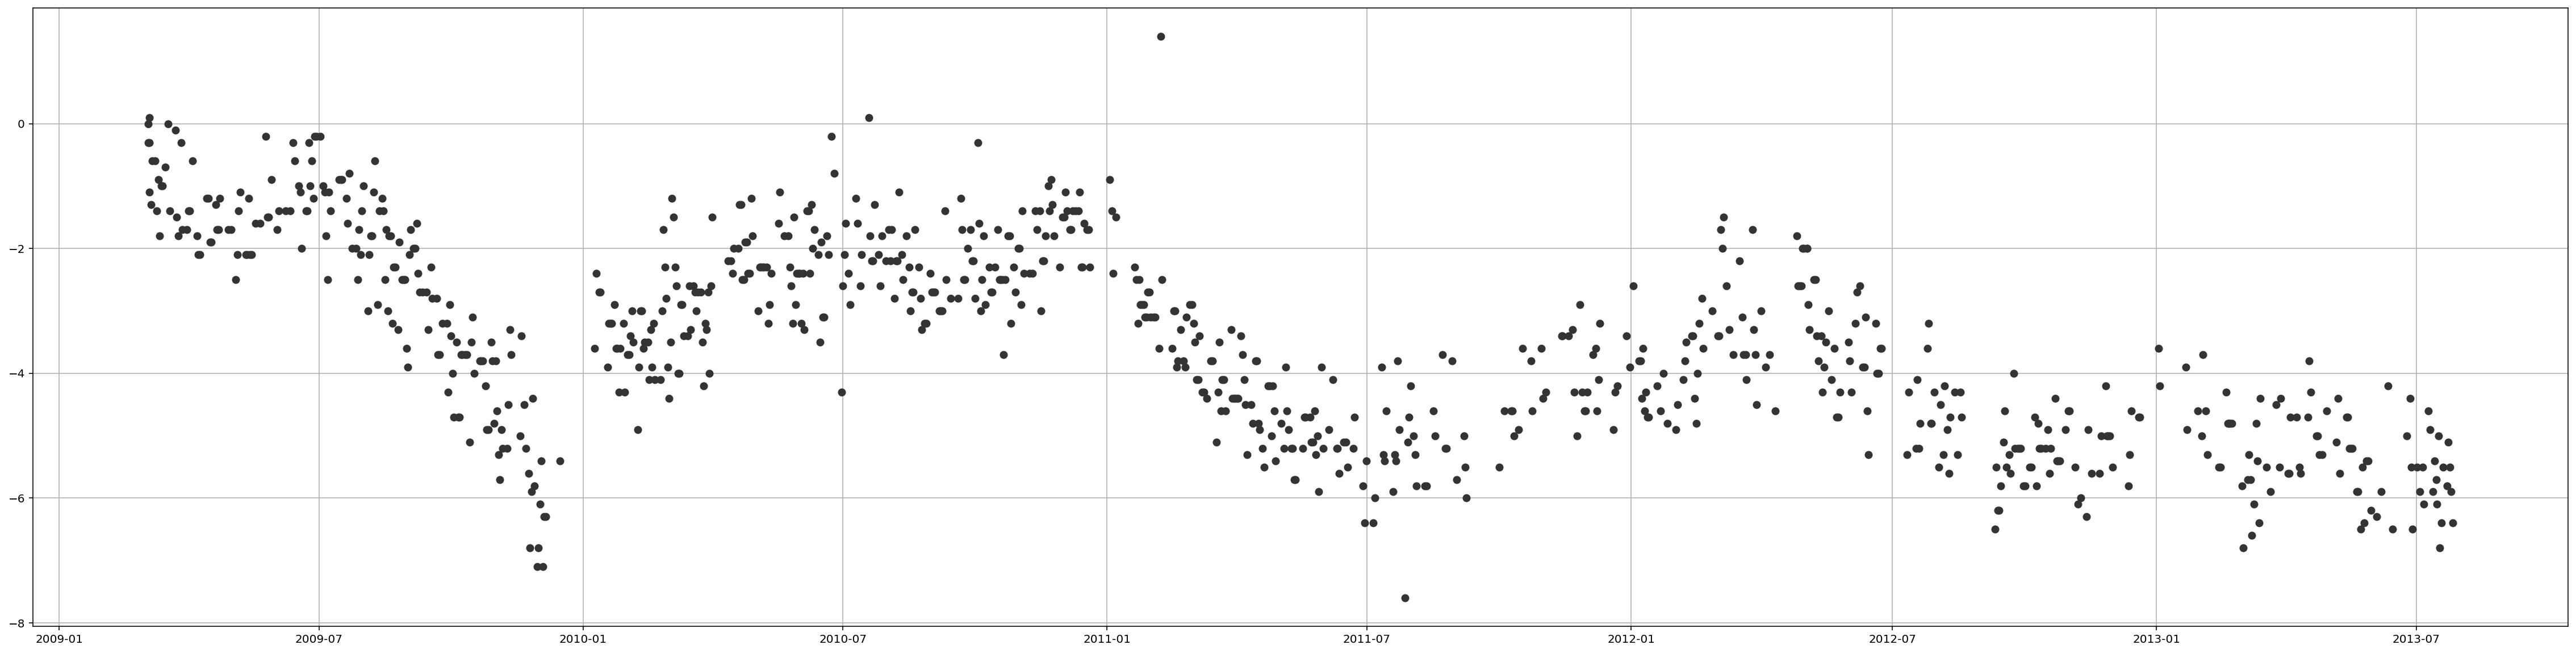

In [12]:
plt.rcParams["figure.figsize"] = 40, 10

fig = plt.figure()
plt.plot_date(Xd, Y, ".", color=dark, markersize=12)
plt.grid()

# A few first ideas

We might naïvely try GP regression with a stationary kernel. This will happily draw a smooth line through the data, but since it does not use any of the data's underlying causal structure, it can not extrapolate meaningfully, or tell us anything about the effect of life-style choices.

In [20]:
# the content in this cell is copied almost verbatim from lecture 6 (GPs)
# basic GP regression:


def kernel(f):
    return lambda a, b: np.array(
        [[np.float64(f(a[i], b[j])) for j in range(b.size)]
         for i in range(a.size)]
    )


def SE(a, b, ell):
    # Square exponentia / RBF / Gaussian kernel
    return np.exp(-((a - b) ** 2) / 2.0 / ell ** 2)


# define the GP:


def m(x):
    return 0.0 * x  # mean function


ell = 30.0  # days
theta = .1
k = kernel(lambda a, b: theta**2 * SE(a, b, ell))

a few other kernel options, if you want to play around with them:

In [ ]:
def Wiener(a, b, offset):
    # Wiener process (e.g. offset = min(t) - 1.0)
    return minimum(a - offset, b - offset)


def OU(a, b, ell):
    # Ornstein Uhlenbeck:
    return exp(-abs(a - b) / ell ** 2)


# Cubic splines (integrated Wiener). E.g.: c=1,o=-9
def spline3(a, b, c, o):
    return c ** 2 * (
        minimum(a - o, b - o) ** 3 / 3.0 + 0.5 *
        abs(a - b) * minimum(a - o, b - o) ** 2
    )


# linear
xoffset = np.mean(X)


def linear(a, b, offset):
    return (a - offset) * (b - offset)

In [21]:
# basic GP inference
# (the @ notation is shorthand for np.dot in python 3)

kXX = k(X, X)  # prior covariance on data ("train")
ktt = k(t, t)  # prior covariance of predictive ("test")
ktX = k(t, X)  # covariance between the latter and the former

alpha = solve(kXX + sigma ** 2 * np.eye(N), ktX.T).T  # the expensive
mpost = alpha @ Y  # posterior mean
vpost = ktt - alpha @ ktX.T  # posterior covariance
spost = np.sqrt(
    np.diag(vpost)
)  # sqrt of diagonal is marginal std-dev (the "sausage of uncertainty for plotting")
samples = (
    cholesky(vpost + 1e-9 * np.eye(Nt)) @ randn(Nt, 3) + mpost[:, np.newaxis]
)  # drawing posterior samples (chol(cov) * rand + mean)

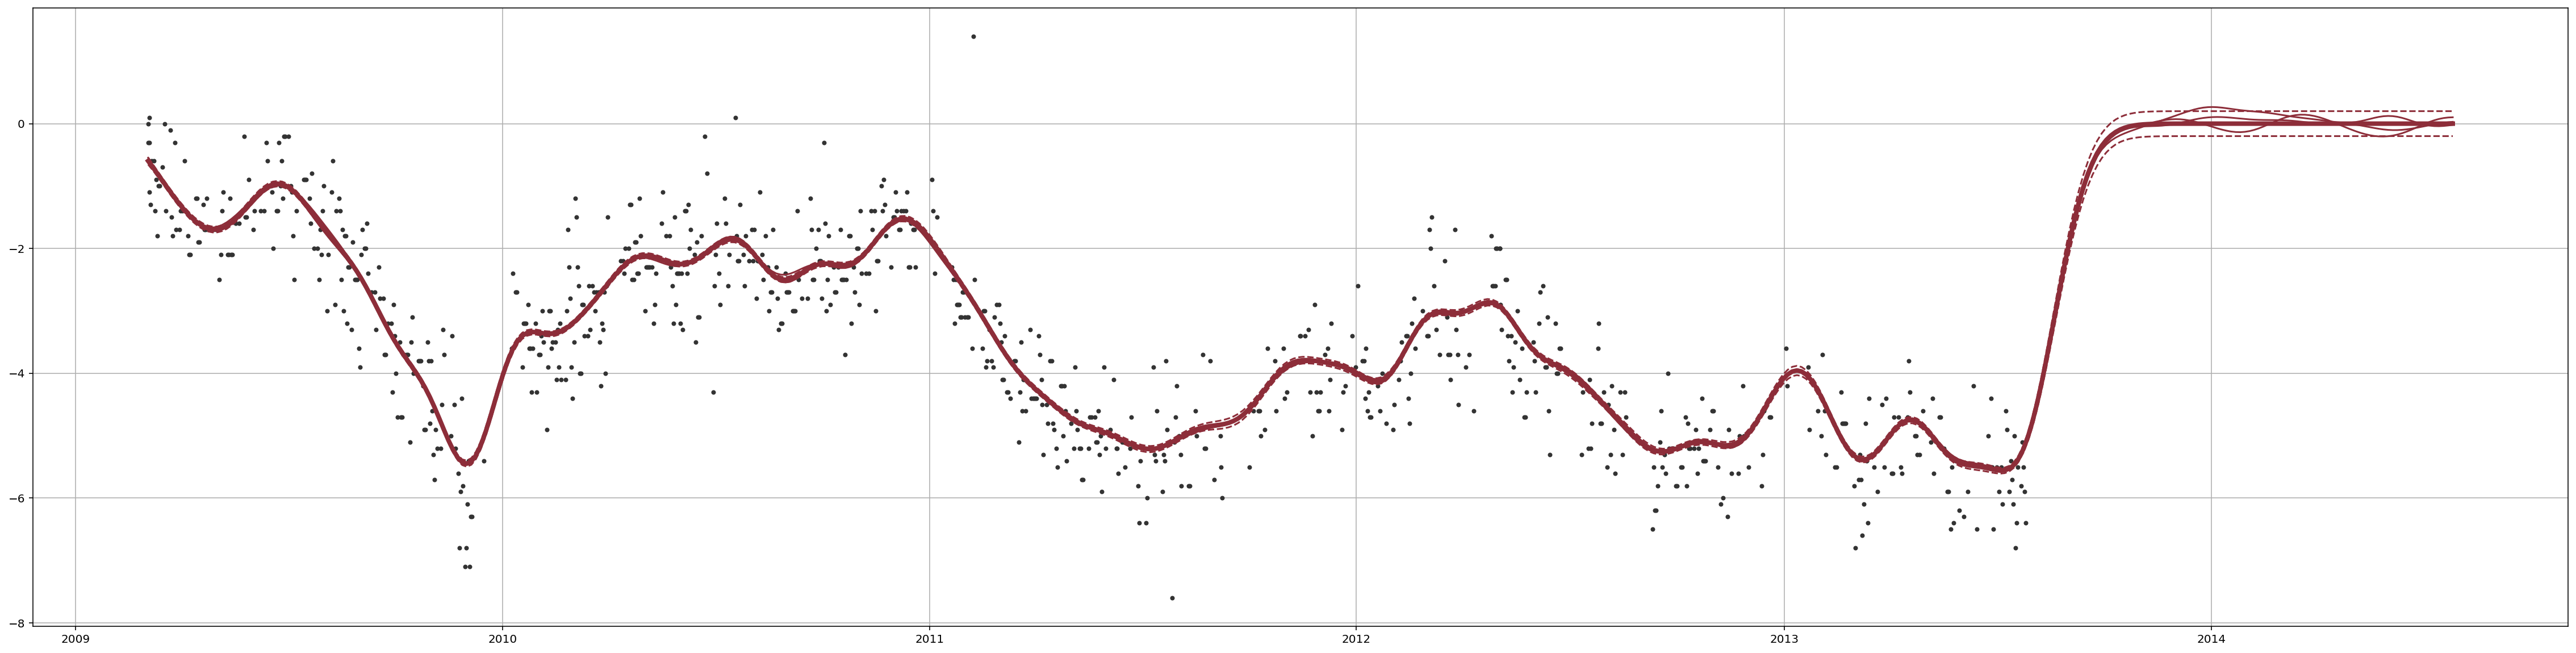

In [22]:
# plotting
plt.rcParams["figure.figsize"] = 40, 10
fig = plt.figure()
ax = fig.gca()
ax.plot_date(Xd, Y, ".", color=dark)
ax.plot(t, mpost, "-", color=red, lineWidth=4)
ax.plot(t, mpost + 2 * spost, "--", color=red)
ax.plot(t, mpost - 2 * spost, "--", color=red)
ax.plot(t, samples, "-", color=red)
ax.grid()

# A better model

To make use of the causal structure, and make meaningful inferences, encode prior knowledge about the underlying lifestyle choices that are thought to have affected the data. The shape of the feature functions is itself a design choice, and may be questioned. In modelling situations such as this, *everything* can always be questioned. There is no way around this. It is the principal role of science to formalise and steer the debate about such questions for the most important questions around our world and our life in it; but there is no established scientific theory for the kind of mundane questions addressed in this dataset. This is the typical case for contemporary machine learning situations. You can not expect someone to give you the *right* model. 

### defining features

We will assume that the observed behaviour stems from a sum of separate components
\begin{align}
f(t) &= f_{SE}(t) + f_{W}(t) + f_{run}(t) + \dots f_{veg}(t)  \tag{$\star$}\\
&= \begin{bmatrix} 1 & 1 & \cdots & 1 \end{bmatrix} 
\begin{bmatrix} f_{SE}(t) \\ f_{W}(t) \\ \vdots \\ f_{veg}(t) \end{bmatrix},\\
\text{where}\qquad
f_{SE} &\sim \mathcal{GP}(0,k_{SE})\\
f_{W} &\sim \mathcal{GP}(0,k_{W}) \text{ are noise processes, and}\\
f_{run}(t) &= \phi^T _{run}(t) w_{run}\\
\end{align}
etc. for each activity. We will assume Gaussian priors and likelihood 
$$p(w) = \mathcal{N}(w;0,\operatorname{diag}(\vec{\theta}^2)$$
$$p(Y | f) = \mathcal{N}(Y;f_T,\sigma^2 I)$$

#### the time ranges of the tracked activities

In [26]:
# time frame of running
runstart = date2num(datetime(2009, 7, 1))
runend = date2num(datetime(2009, 12, 5))

# time frame of first diet
dietstart1 = date2num(datetime(2009, 3, 4))
dietend1 = date2num(datetime(2009, 4, 15))
# second diet
dietstart2 = date2num(datetime(2011, 1, 1))
dietend2 = date2num(datetime(2011, 5, 30))

# time frame of gym
gymstart = date2num(datetime(2012, 4, 1))
gymend = max(X)

# eating vegetarian
vegstart = date2num(datetime(2013, 5, 13))
vegend = date2num(datetime(2013, 6, 27))

# gorgeing
eatstart1 = date2num(datetime(2009, 12, 5))
eatend1 = date2num(datetime(2010, 5, 10))

eatstart2 = date2num(datetime(2011, 5, 30))
eatend2 = date2num(datetime(2012, 4, 1))

#### and features

* All weights will be interpreted in units of *grams per day*
* The choice of linear features is deliberate. Exercise: Criticically evaluate this choice and suggest alternatives

In [27]:
phi_run = (
    lambda t: (
        (t > runstart) * (t < runend) * (t - runstart)
        + (t >= runend) * (runend - runstart)
    )
    / 1000.0
)
phi_diet = (
    lambda t: (
        (t > dietstart1) * (t < dietend1) * (t - dietstart1)
        + (t >= dietend1) * (dietend1 - dietstart1)
        + (t > dietstart2) * (t < dietend2) * (t - dietstart2)
        + (t >= dietend2) * (dietend2 - dietstart2)
    )
    / 1000.0
)
phi_eat = (
    lambda t: (
        (t > eatstart1) * (t < eatend1) * (t - eatstart1)
        + (t >= eatend1) * (eatend1 - eatstart1)
        + (t > eatstart2) * (t < eatend2) * (t - eatstart2)
        + (t >= eatend2) * (eatend2 - eatstart2)
    )
    / 1000.0
)
phi_veg = (
    lambda t: (
        (t > vegstart) * (t < vegend) * (t - vegstart)
        + (t >= vegend) * (vegend - vegstart)
    )
    / 1000.0
)
phi_gym = (
    lambda t: (
        (t > gymstart) * (t < gymend) * (t - gymstart)
        + (t >= gymend) * (gymend - gymstart)
    )
    / 1000.0
)

plot of the features:

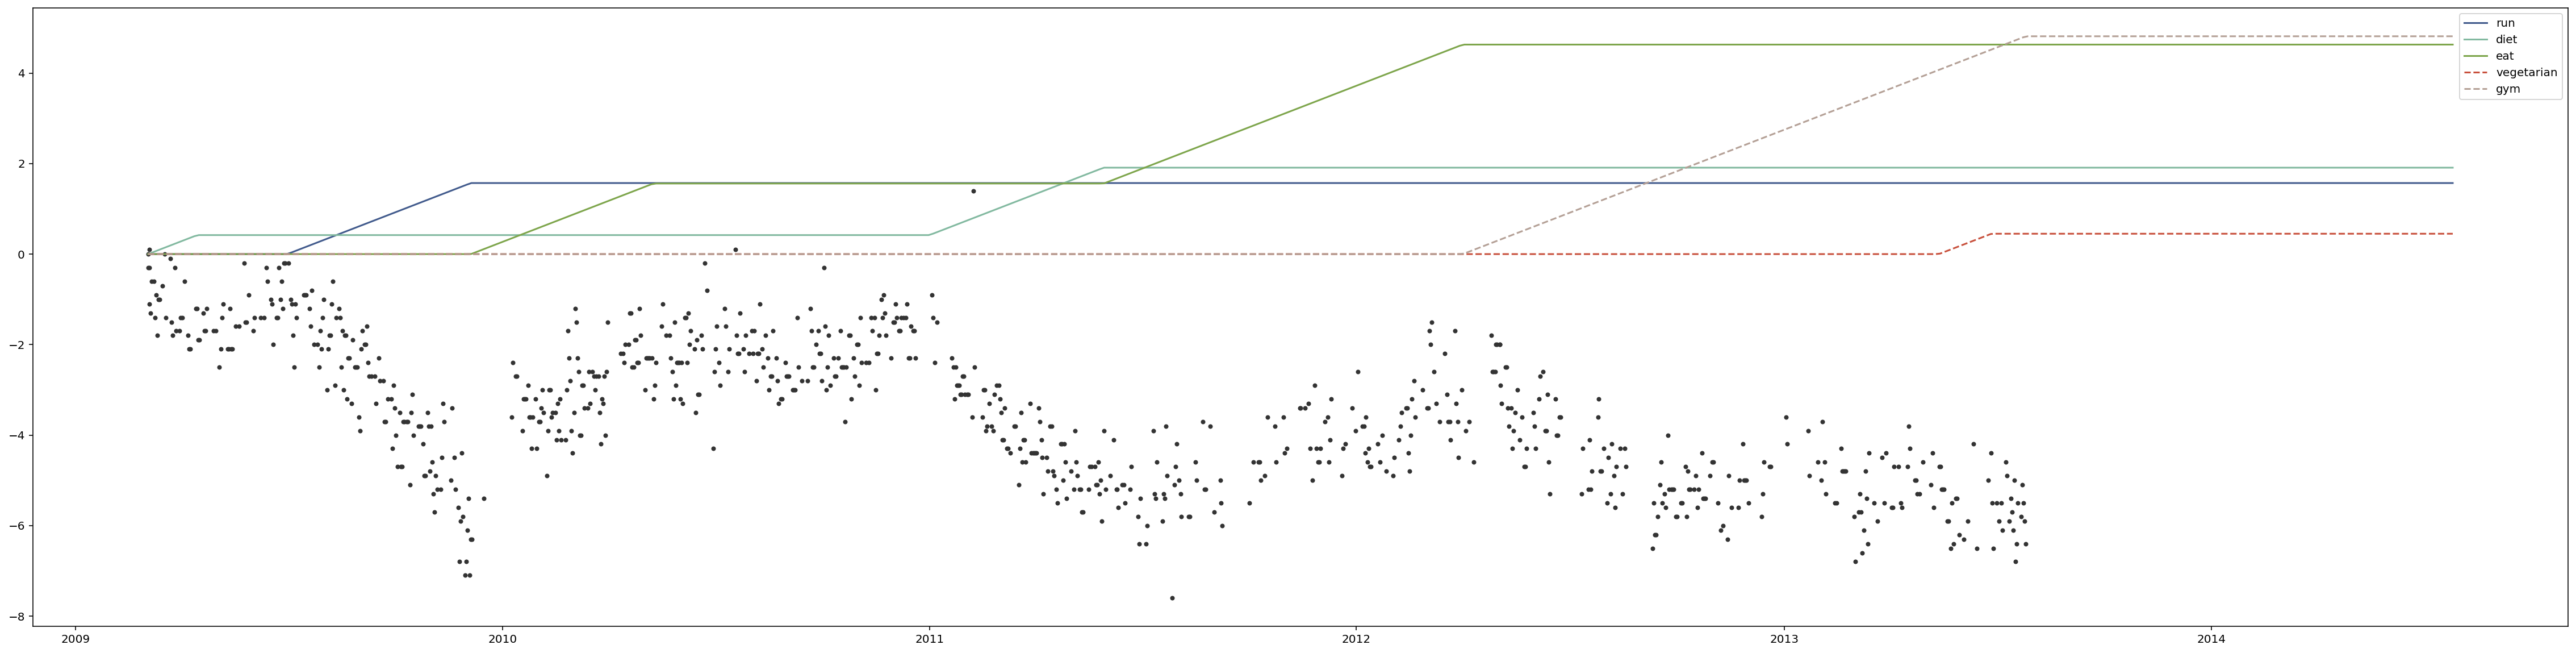

In [28]:
plt.rcParams["figure.figsize"] = 40, 10
fig = plt.figure()
plt.plot_date(Xd, Y, ".", color=dark)

plt.plot(t, 10 * phi_run(t), "-", color=tuesec1, label="run")
plt.plot(t, 10 * phi_diet(t), "-", color=tuesec4, label="diet")
plt.plot(t, 10 * phi_eat(t), "-", color=tuesec5, label="eat")
plt.plot(t, 10 * phi_veg(t), "--", color=tuesec7, label="vegetarian")
plt.plot(t, 10 * phi_gym(t), "--", color=tuesec9, label="gym")
plt.legend()

## define overall kernel (with derivatives, for hyperparameter optimization)

In [35]:
"""
this is what one would *like* to do, from a functional programming perspective. 
Unfortunately, python is not great when it comes to functional programming. 
So instead, below, there's an implementation using for-loops.
"""


def weight_kernel(a, b, hypers):
    # use logarithmic re-scaling of hyperparameters to ensure positivity, use full float range
    [ell_SE, tSE, tW, trun, tveg, tdiet, tgym, teat] = exp(hypers)

    # square exponential kernel
    SE = (
        lambda a, b: exp(-((a - b) ** 2) / 2.0 / ell_SE ** 2) / 1000 ** 2
    )  # to get units of grams per day
    kSE = kernel(SE)

    # Wiener process
    offset = min(t) - 1.0
    Wiener = (
        lambda a, b: minimum(a - offset, b - offset) / 1000 ** 2
    )  # to get units of grams per day
    kW = kernel(Wiener)

    # parametric kernels
    krun = kernel(lambda a, b: phi_run(a) * phi_run(b))
    kdiet = kernel(lambda a, b: phi_diet(a) * phi_diet(b))
    kveg = kernel(lambda a, b: phi_veg(a) * phi_veg(b))
    kgym = kernel(lambda a, b: phi_gym(a) * phi_gym(b))
    keat = kernel(lambda a, b: phi_eat(a) * phi_eat(b))

    # overall kernel
    kab = (
        tSE ** 2 * kSE(a, b)
        + tW ** 2 * kW(a, b)
        + trun ** 2 * krun(a, b)
        + tdiet ** 2 * kdiet(a, b)
        + tveg ** 2 * kveg(a, b)
        + tgym ** 2 * kgym(a, b)
        + teat ** 2 * keat(a, b)
    )
    return kab


# too expensive!
# k = lambda a,b: weight_kernel(a,b,hypers0)
# kXX = k(X,X)
# ktt = k(t,t)
# ktX = k(t,X)

In [30]:
def weight_kernel(a, b, hypers):
    """
        weight kernel takes in inputs 
        a,b       kernel inputs in |R
        hypers    kernel hyperparamters, in |R^8, interpreted as
        hypers = log([ell_SE,tSE,tW,trun,tveg,tdiet,tgym,teat])

            ell_SE — length scale of stationary noise
            tSE    – signal std-dev of stationary noise

            tW     – signal std-dev of random walk noise

            trun
            ... 
            teat   – signal std-dev of the individual lifestyle choices effects 

        (we use logarithmic re-scaling of hyperparameters 
        to ensure positivity, use full float range)
    """
    [ell_SE, tSE, tW, trun, tveg, tdiet, tgym, teat] = np.exp(hypers)

    # square exponential kernel
    # a stationary component, modeling a smooth mean-reverting process (digestion)
    SE = (
        lambda a, b: np.exp(-((a - b) ** 2) / 2.0 / ell_SE ** 2) / 1000 ** 2
    )  # to get units of grams per day
    kSE = kernel(SE)

    # Wiener process
    # a random walk as a second, additive noise process
    # this will model unexpected events in life, such as forgetting to have lunch
    # one day, attending a wedding the next.
    offset = min(t) - 1.0
    Wiener = (
        lambda a, b: np.minimum(a - offset, b - offset) / 1000 ** 2
    )  # to get units of grams per day
    kW = kernel(Wiener)

    kSEab = kSE(a, b)
    kWab = kW(a, b)

    # kernels for the individual activities (scales are handled below)
    krunab = np.outer(phi_run(a), phi_run(b))  # phi_r * phi_r.T
    kdietab = np.outer(phi_diet(a), phi_diet(b))  # as above
    kvegab = np.outer(phi_veg(a), phi_veg(b))
    kgymab = np.outer(phi_gym(a), phi_gym(b))
    keatab = np.outer(phi_eat(a), phi_eat(b))

    # the overall kernel is the SUM of individual components,
    # encoding the assumption that the weight development is a sum of
    # separate causal effects for the lifestyle choices, and the two noise processes
    # the hyperparameters come in here
    kab = (
        tSE ** 2 * kSEab
        + tW ** 2 * kWab
        + trun ** 2 * krunab
        + tdiet ** 2 * kdietab
        + tveg ** 2 * kvegab
        + tgym ** 2 * kgymab
        + teat ** 2 * keatab
    )

    """
    computing derivatives (for hyperparameter optimization)
    Note that 
    df / dlog(x) = df/dx * dx/dlog(x) 
                 = df/dx * dexp(log(x))/dlog(x) 
                 = df/dx * x
    """

    dist = kernel(lambda a, b: a - b)  # to simplify things

    dkdell = tSE ** 2 * kSEab * \
        dist(a, b) ** 2 / ell_SE ** 2  # dk / d log ellSE
    dkdtSE = 2 * tSE ** 2 * kSEab  # dk / d log theta_SE
    dkdtW = 2 * tW ** 2 * kWab  # dk / d log theta_W
    dkdtrun = 2 * trun ** 2 * krunab  # dk / d log theta_run
    dkdtdiet = 2 * tdiet ** 2 * kdietab  # dk / d log theta_diet
    dkdtveg = 2 * tveg ** 2 * kvegab  # dk / d log theta_veg
    dkdtgym = 2 * tgym ** 2 * kgymab  # dk / d log theta_gym
    dkdteat = 2 * teat ** 2 * keatab  # dk / d log theta_eat

    dkdhyper = [dkdell, dkdtSE, dkdtW, dkdtrun,
                dkdtveg, dkdtdiet, dkdtgym, dkdteat]

    return kab, dkdhyper

In [33]:
# initial hyperaparameters, spelt out for easier interpretation:
ellSE0 = 1  # length of stationary variations [days]
tSE0 = 200  # scale of stationary variations [gram]
tW0 = 50  # scale of diffusion [gram]
effect = 10  # prior scale of various causal effects [gram/day]
hypers0 = np.log(
    np.array([ellSE0, tSE0, tW0, effect, effect, effect, effect, effect]))

### Evaluating the Model

We begin by making a plot of prior samples and seeing whether they look like the data. 

In [34]:
kXX, dkXXdh = weight_kernel(X, X, hypers0)
ktt, dkttdh = weight_kernel(t, t, hypers0)
ktX, dktXdh = weight_kernel(t, X, hypers0)

A good way to test this is to see if we can *hide* the true data among the prior samples

(-10.0, 10.0)

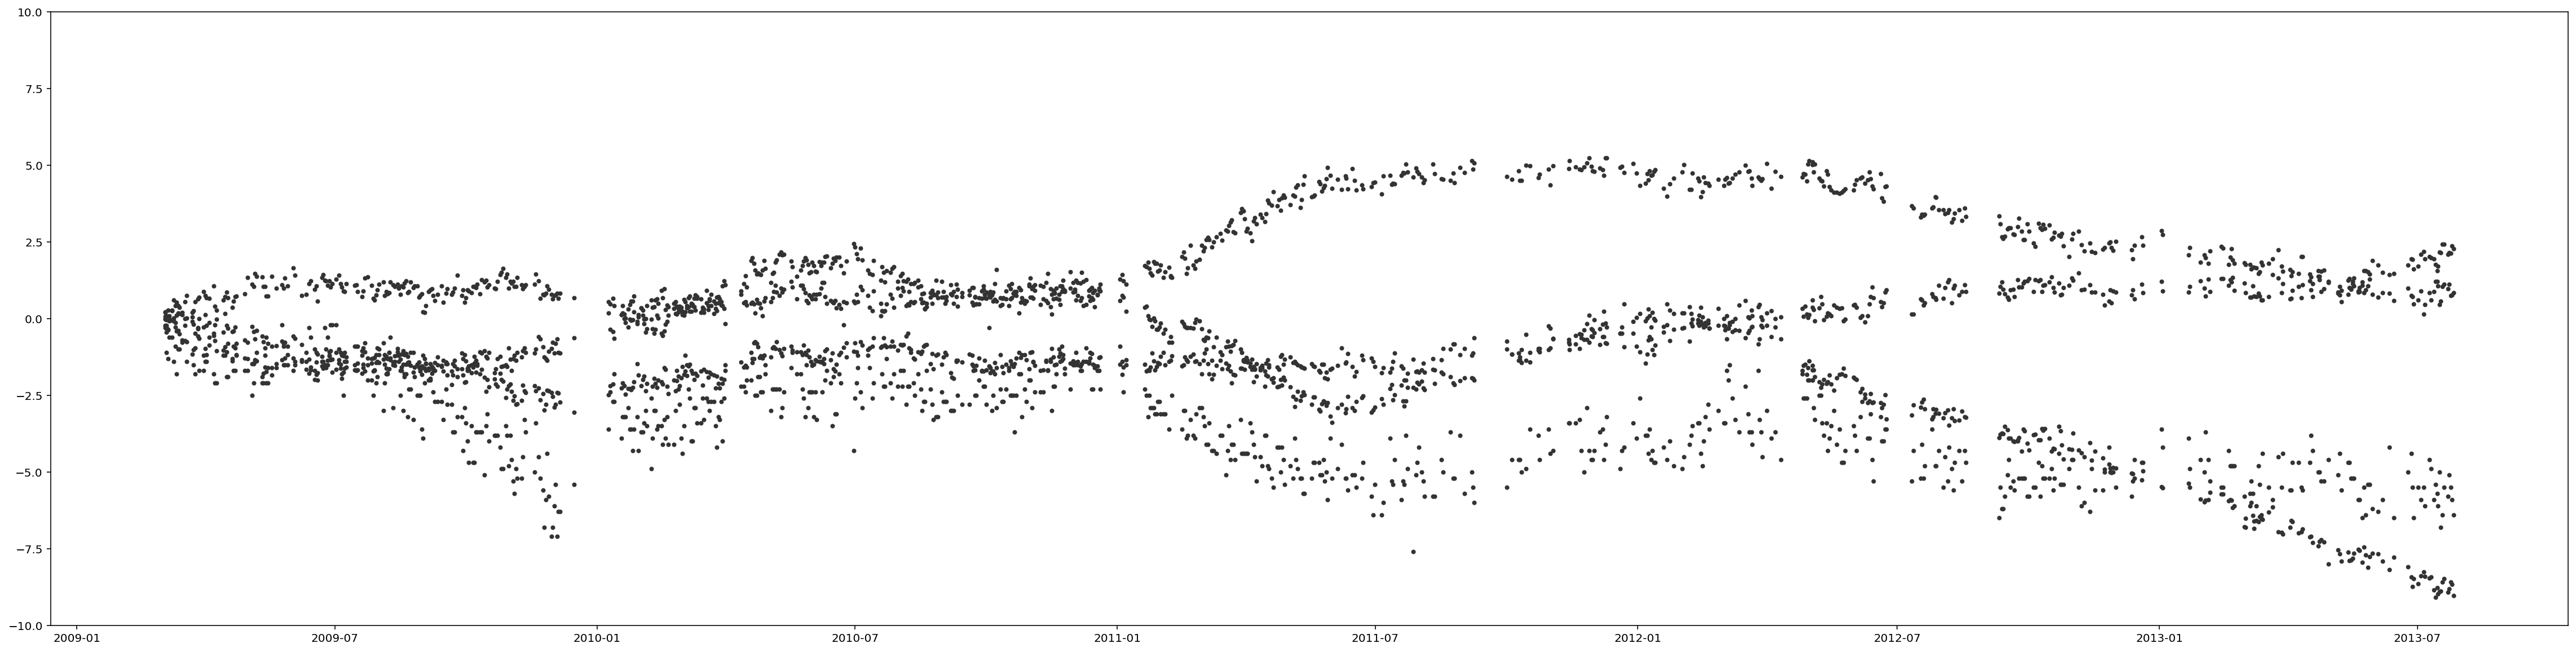

In [35]:
# prior samples:
prior_samples = cholesky(kXX + 1e-9 * np.eye(N)) @ randn(N, 3)

fig = plt.figure()
plt.plot_date(Xd, Y, ".", color=dark)
plt.plot(X, prior_samples + sigma * randn(N, 3), ".", color=dark)
plt.ylim([-10, 10])

This doesn't look bad, but the scales for some of the features are clearly off. In particular, the "run" feature probably needs a larger scale, while the "gym" feature may be a bit too strong. Instead of fiddling around with the scales manually, let's leave this to a numerical algorithm.

### hierarchical inference

Recall that (since we are using prior mean 0

\begin{align}
p(Y\mid \theta) &= \int p(Y| f) p(f| \theta) \,df \\
-2\log p(y \mid \theta) &=  Y^T \underbrace{(k_{XX} (\theta) + \sigma^2 I)^{-1}}_{=:G^{-1}(\theta)} Y + \log |G|
\end{align}

With derivative
\begin{align}
\frac{\partial -2\log p(y \mid \theta)}{\partial \theta} &= - Y^T G^{-1}\frac{\partial G}{\partial \theta} G^{-1} Y + \operatorname{tr}\left(G^{-1}\frac{\partial G}{\partial \theta}\right)
\end{align}


In [36]:
# define log likelihood
def loglik(hypers, verbose=True):
    """
        computes the log likelihood of the generative model on the training data, 
        as a function of the hyperparameters, with derivative. 
        Input:
        hypers — log hyperparameters, as defined for the kernel 
                 (these are actually just handed on to the kernel)
        verbose — whether to generate output (default: true)
    """
    if verbose:
        print("computing log likelihood and gradient at"),
        print(np.exp(hypers))

    K, dK = weight_kernel(X, X, hypers)  # build Gram matrix, with derivatives
    G = K + sigma ** 2 * np.eye(N)  # add noise (defined above)
    (s, ld) = np.linalg.slogdet(
        G
    )  # compute log determinant of symmetric pos.def. matrix
    a = np.linalg.solve(G, Y)  # G \ Y
    loglik = np.inner(Y, a) + ld  # (Y / G) * Y + log |G|

    if verbose:
        print("log likelihood:")
        print(loglik)

    dloglik = np.zeros(8)
    for i in range(8):
        dloglik[i] = -np.inner(a, dK[i] @ a) + np.trace(solve(G, dK[i]))

    return loglik, dloglik

testing the gradient (this is just a sanity check, but it's a good habit to copy if you're writing your own gradients

In [37]:
[l, dl] = loglik(hypers0)
e = 1e-6

dtrue = np.zeros(8)
for i in range(8):
    print(i)
    hypers1 = hypers0.copy()
    hypers2 = hypers0.copy()
    hypers2[i] += e
    hypers1[i] -= e
    [l1i, d1i] = loglik(hypers1)
    [l2i, d2i] = loglik(hypers2)
    dtrue[i] = (l2i - l1i) / (2 * e)

dl, dtrue, (dl - dtrue) / (dtrue + dl)

computing log likelihood and gradient at
[  1. 200.  50.  10.  10.  10.  10.  10.]
log likelihood:
5371.84841119476
0
computing log likelihood and gradient at
[  0.999999 200.        50.        10.        10.        10.
  10.        10.      ]


KeyboardInterrupt: 

Now it's time to optimize. We use scipy's built-in optimization routine. It takes the handle to the objective (the log likelihood), initial hyperparameter guesses, and flags telling it to use the provided gradient (try it without, it likely won't work). And we allow 15 steps, even this takes a few minutes.

In [38]:
import scipy.optimize

hypers_opt = scipy.optimize.minimize(
    loglik, hypers0, jac=True, options={"maxiter": 15, "disp": True}
)

computing log likelihood and gradient at
[  1. 200.  50.  10.  10.  10.  10.  10.]
log likelihood:
5371.84841119476
computing log likelihood and gradient at
[  0.57911839 463.53155323  56.55438637  10.01522977   9.99876599
  10.00947227   9.99846148  10.00054736]
log likelihood:
462.8738138629076
computing log likelihood and gradient at
[5.24174235e+04 2.71490889e+06 6.69447313e+01 1.24364279e+01
 9.81473639e+00 1.18933766e+01 9.71939932e+00 1.01166299e+01]
log likelihood:
16275.3684465328
computing log likelihood and gradient at
[  1.40061031 907.03067259  57.29733018  10.18444397   9.98440343
  10.14393542   9.97658455  10.00948208]
log likelihood:
1403.3085661666796
computing log likelihood and gradient at
[  0.73666598 556.56252223  56.75585115  10.06105378   9.99485067
  10.04593088   9.99249607  10.00298095]
log likelihood:
345.78348256630636
computing log likelihood and gradient at
[6.71988382e-01 1.13754874e+03 3.76935040e-01 3.16632311e+01
 8.99870184e+00 2.74818048e+01 8.4694

In [39]:
# let's have a look at the learned hyperparameters.
# These are returned in a data structure by the optimiser
print(hypers_opt)

      fun: 258.0639373729514
 hess_inv: array([[ 1.07061124e-03,  3.06068386e-04, -1.07508949e-03,
         3.45873025e-03,  4.48556242e-03,  4.69112050e-03,
         7.88565239e-03,  1.74267287e-03],
       [ 3.06068386e-04,  4.21330045e-04, -8.15588882e-04,
         4.87975058e-04, -2.55014168e-03,  1.39307277e-03,
         3.81980125e-03, -2.66279095e-04],
       [-1.07508949e-03, -8.15588882e-04,  1.04780268e-02,
         3.66459709e-03,  6.60811153e-03, -1.57995537e-03,
        -2.76798953e-02, -3.56886599e-03],
       [ 3.45873025e-03,  4.87975058e-04,  3.66459709e-03,
         2.69836693e-01,  4.40664853e-02, -9.41585502e-02,
        -6.69225821e-02,  6.25982490e-02],
       [ 4.48556242e-03, -2.55014168e-03,  6.60811153e-03,
         4.40664853e-02,  1.08058026e+00,  4.43450138e-02,
        -3.30798418e-01,  1.19105979e-02],
       [ 4.69112050e-03,  1.39307277e-03, -1.57995537e-03,
        -9.41585502e-02,  4.43450138e-02,  3.08762251e-01,
        -6.79405787e-02, -2.15936937e

In [40]:
opt_hypers = hypers_opt.x
# [ell_SE, tSE, tW, trun, tveg, tdiet, tgym, teat] = np.exp(hypers)
print(np.exp(opt_hypers))

[6.28240521e-01 6.34512164e+02 8.97570835e+01 2.91674524e+01
 9.36100550e-01 2.51340679e+01 3.45529016e+00 1.16646692e+01]


## Evaluation

Now that we have a good model, we can inspect it and run inference. 

We will need these matrices here:

In [41]:
kXX, dkXXdh = weight_kernel(X, X, opt_hypers)
ktt, dkttdh = weight_kernel(t, t, opt_hypers)
ktX, dktXdh = weight_kernel(t, X, opt_hypers)

First, let's draw some samples from the prior with optimized hyperparameters and see if we can "hide" the true data among them.

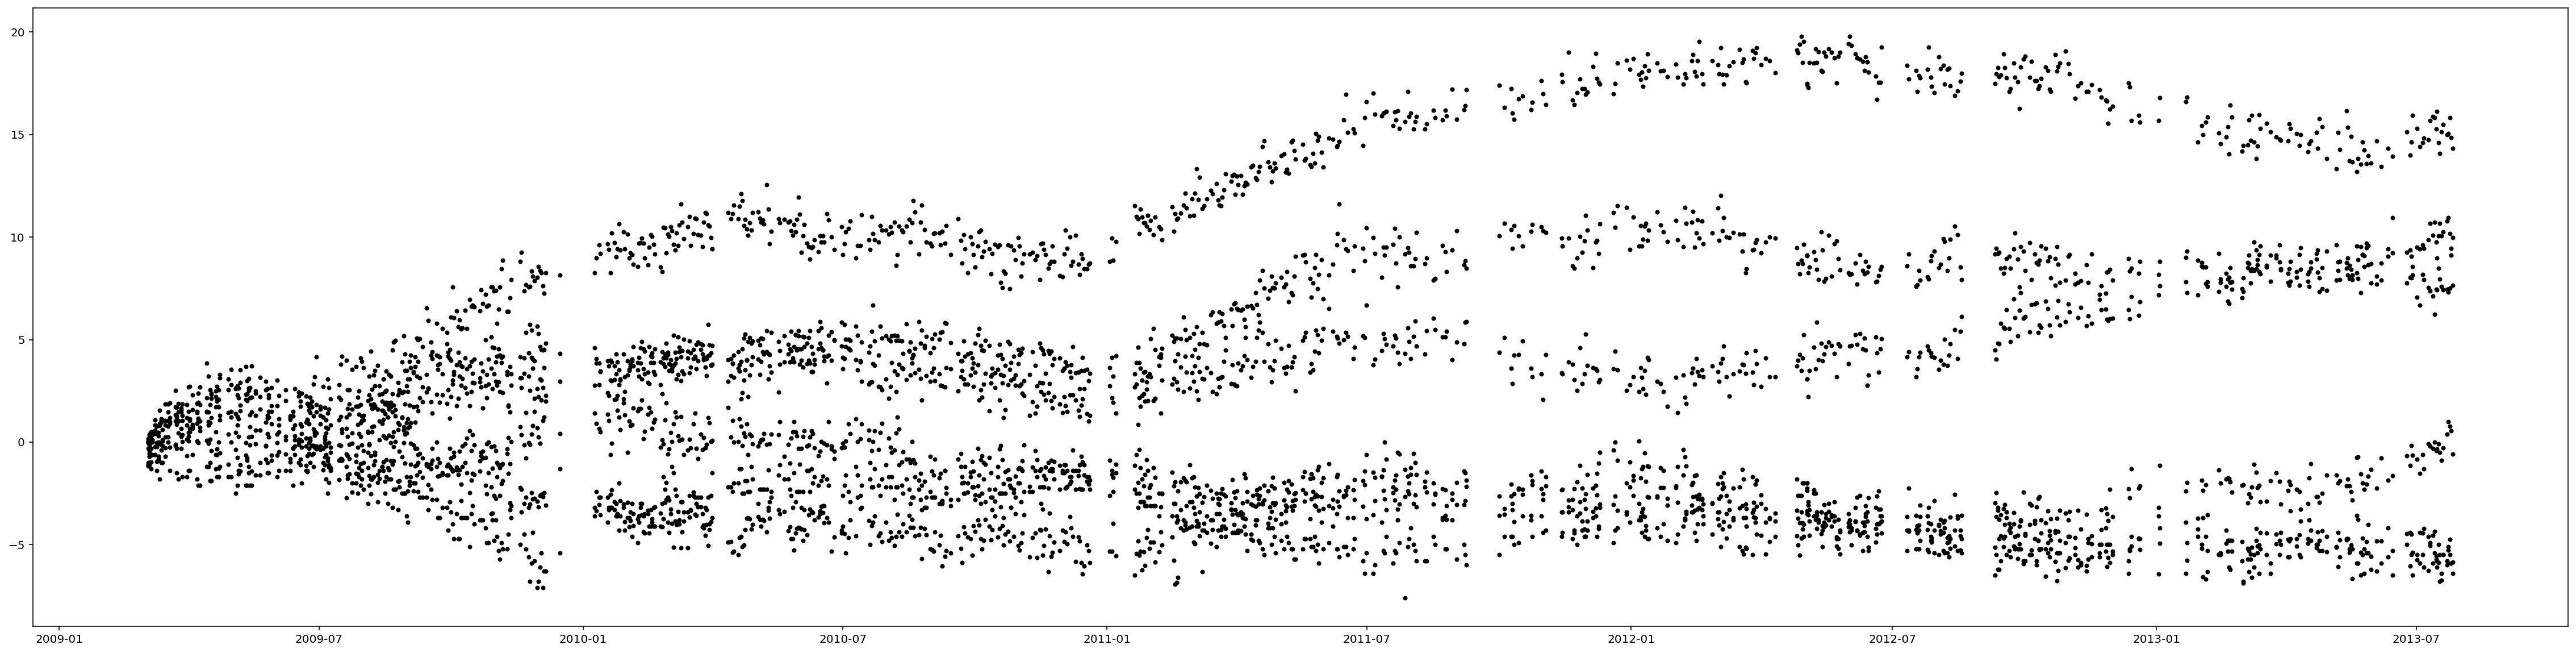

In [43]:
# prior samples:
prior_samples = cholesky(kXX + 1e-9 * np.eye(N)) @ randn(N, 5)

# plot:
fig = plt.figure()
plt.plot_date(Xd, Y, ".", color="k")
plt.plot_date(X, prior_samples + sigma * randn(N, 5), ".", color="k")

Posterior Predictive

(-10.0, 5.0)

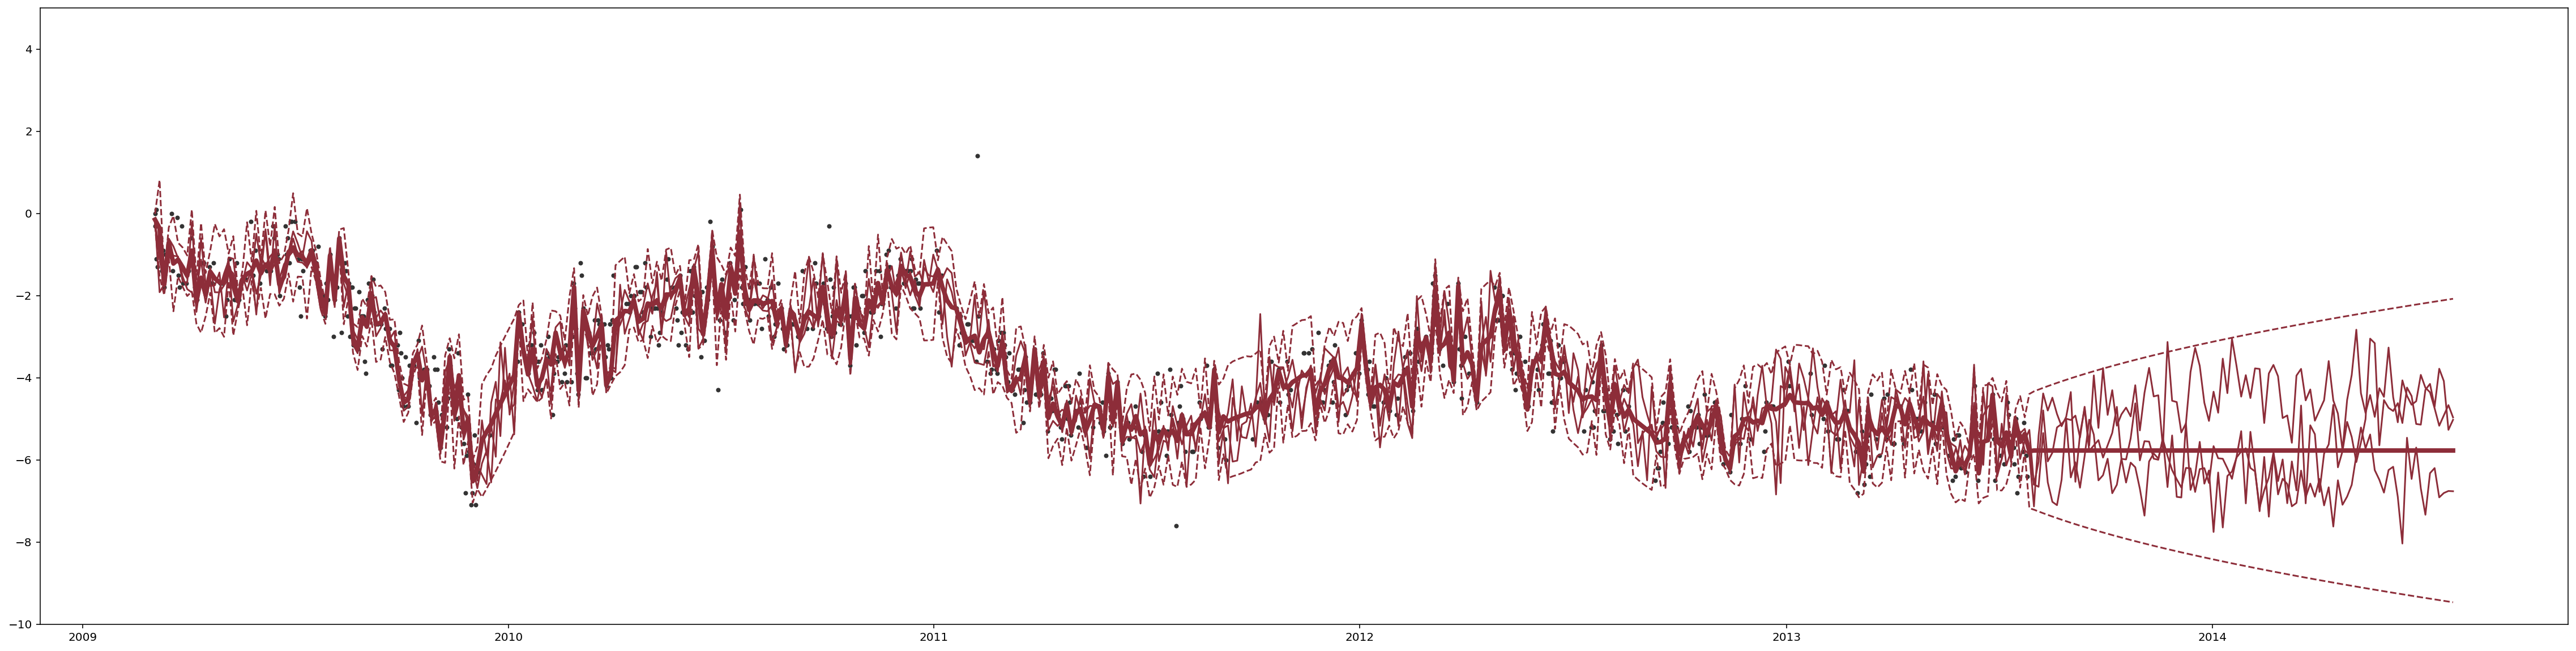

In [44]:
alpha = solve(kXX + sigma ** 2 * np.eye(N), ktX.T).T  # the expensive bit
mpost = alpha @ Y  # posterior mean
vpost = ktt - alpha @ ktX.T  # posterior covariance
spost = np.sqrt(np.diag(vpost))  # `sausage of uncertainty'
samples = cholesky(vpost + 1e-9 * np.eye(Nt)) @ randn(Nt,
                                                      3) + mpost.reshape(Nt, 1)

fig = plt.figure()

plt.plot_date(Xd, Y, ".", color=dark)
plt.plot(t, mpost, "-", color=red, lineWidth=4)
plt.plot(t, mpost + 2 * spost, "--", color=red)
plt.plot(t, mpost - 2 * spost, "--", color=red)
plt.plot(t, samples, "-", color=red)

plt.ylim([-10, 5])

## Computing the Posteriors on the feature weights:

From ($\star$) above, the posterior over each component of the sum of functions is
\begin{align}
p(w| Y) &= \mathcal{N}\bigg(w;\quad \operatorname{diag}(\vec{\theta}^2) \Phi_X ^T G^{-1}Y,  
\quad \operatorname{diag}(\vec{\theta}^2) \left(I - \Phi_X ^T G^{-1} \Phi_X \operatorname{diag}(\vec{\theta}^2)\right) \bigg)
\end{align}

In [45]:
[ell_SE, tSE, tW, trun, tveg, tdiet, tgym, teat] = np.exp(opt_hypers)
# kXX, dkXXdh = weight_kernel(X,X,opt_hypers)

cholK = cho_factor(kXX + 1e-9 * np.eye(N))

# kernel weights (G^-1 Y)
alpha = cho_solve(cholK, Y)

# predictive means for the parametric weights
mrun = trun ** 2 * phi_run(X) @ alpha
mdiet = tdiet ** 2 * phi_diet(X) @ alpha
mgym = tgym ** 2 * phi_gym(X) @ alpha
mveg = tveg ** 2 * phi_veg(X) @ alpha
meat = teat ** 2 * phi_eat(X) @ alpha

# predictive (marginal) variances
vrun = trun ** 2 * (1 - trun ** 2 * phi_run(X) @ cho_solve(cholK, phi_run(X)))
vdiet = tdiet ** 2 * (1 - tdiet ** 2 * phi_diet(X) @
                      cho_solve(cholK, phi_diet(X)))
vgym = tgym ** 2 * (1 - tgym ** 2 * phi_gym(X) @ cho_solve(cholK, phi_gym(X)))
vveg = tveg ** 2 * (1 - tveg ** 2 * phi_veg(X) @ cho_solve(cholK, phi_veg(X)))
veat = teat ** 2 * (1 - teat ** 2 * phi_eat(X) @ cho_solve(cholK, phi_eat(X)))

# and for the nonparametric components:
# copied from above (not elegant coding, but perhaps easier to understand than exposing components of the kernel above)
# square exponential kernel
SE = (
    lambda a, b: tSE ** 2 *
    np.exp(-((a - b) ** 2) / 2.0 / ell_SE ** 2) / 1000 ** 2
)  # to get units of grams per day
kSE = kernel(SE)
mSE = kSE(X, X) @ alpha
vSE = kSE(X, X) - kSE(X, X) @ cho_solve(cholK, kSE(X, X).T)
sSE = np.sqrt(vSE.diagonal())
PsSE = cholesky(vSE + 1e-8 * np.eye(N)) @ randn(N, 3) + mSE.reshape(
    N, 1
)  # posterior samples

# draws from the SE PRIOR, for comparison below
psSE = cholesky(kSE(X, X) + 1e-9 * np.eye(N)) @ randn(N, 3)

# Wiener noise process
offset = min(t) - 1.0
Wiener = (
    lambda a, b: tW ** 2 * np.minimum(a - offset, b - offset) / 1000 ** 2
)  # to get units of grams per day
kW = kernel(Wiener)
mW = kW(X, X) @ alpha
vW = kW(X, X) - kW(X, X) @ cho_solve(cholK, kW(X, X).T)
sW = np.sqrt(vSE.diagonal())
PsW = cholesky(vW + 1e-8 * np.eye(N)) @ randn(N, 3) + mW.reshape(
    N, 1
)  # posterior samples

# PRIOR samples
psW = cholesky(kW(X, X) + 1e-9 * np.eye(N)) @ randn(N, 3)

generating output

In [46]:
print(
    "Running causes an estimated change of {:3.3} +/- {:2.2} grams per day".format(
        mrun, np.sqrt(vrun)
    )
)
print(
    "Dieting causes an estimated change of {:3.3} +/- {:2.2} grams per day".format(
        mdiet, np.sqrt(vdiet)
    )
)
print(
    "Going to the gym causes an estimated change of {:3.3} +/- {:2.2} grams per day".format(
        mgym, np.sqrt(vgym)
    )
)
print(
    "Eating vegetarian causes an estimated change of {:3.3} +/- {:2.2} grams per day".format(
        mveg, np.sqrt(vveg)
    )
)
print(
    "Gorgeing causes an estimated change of {:3.3} +/- {:2.2} grams per day".format(
        meat, np.sqrt(veat)
    )
)

Running causes an estimated change of -29.2 +/- 7.2 grams per day
Dieting causes an estimated change of -24.7 +/- 6.6 grams per day
Going to the gym causes an estimated change of -2.16 +/- 2.7 grams per day
Eating vegetarian causes an estimated change of -0.0175 +/- 0.93 grams per day
Gorgeing causes an estimated change of 10.4 +/- 4.0 grams per day


plot "noise" residuals

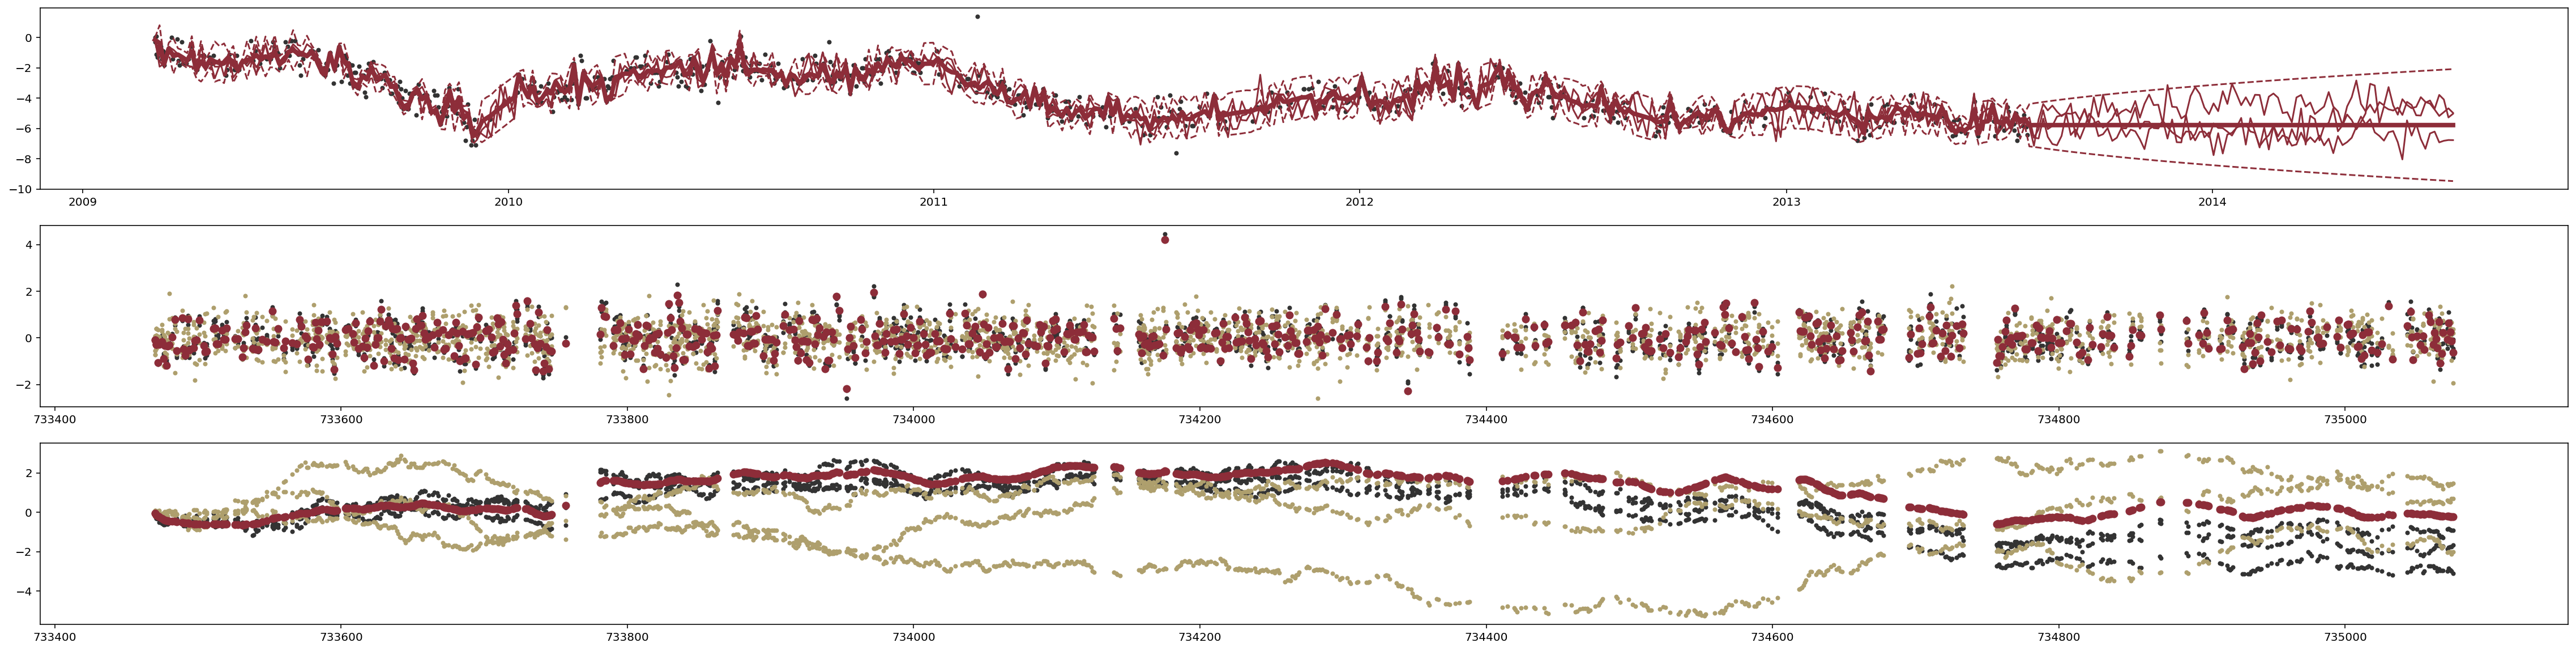

In [47]:
ax = plt.subplot(311)

plt.plot_date(Xd, Y, ".", color=dark)
plt.plot(t, mpost, "-", color=red, lineWidth=4)
plt.plot(t, mpost + 2 * spost, "--", color=red)
plt.plot(t, mpost - 2 * spost, "--", color=red)
plt.plot(t, samples, "-", color=red)

ax = plt.subplot(312)
# plt.plot(X,mSE + 2 * sSE,'--',color=red)
# plt.plot(X,mSE - 2 * sSE,'--',color=red)
plt.plot(X, PsSE, ".", color=dark)
plt.plot(X, psSE, ".", color=gold)
plt.plot(X, mSE, "o", color=red, lineWidth=4)

ax = plt.subplot(313)
# plt.plot(X,mW + 2 * sW,'--',color=red)
# plt.plot(X,mW - 2 * sW,'--',color=red)
plt.plot(X, PsW, ".", color=dark)
plt.plot(X, psW, ".", color=gold)
plt.plot(X, mW, "o", color=red, lineWidth=4)